# Implementation of DANN
Reference: https://arxiv.org/pdf/1505.07818.pdf

In [1]:
import torch
import torchvision
import torch.nn as nn

In [2]:
torch.__version__

'1.2.0'

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

In [4]:
import numpy as np
import datetime
import os, sys

In [5]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [6]:
MODEL_NAME = 'DANN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [7]:
class FeatureExtractor(nn.Module):
    """
        Feature Extractor
    """
    def __init__(self, in_channel=1, hidden_dims=512):
        super(FeatureExtractor, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, hidden_dims, 3, padding=1),
            nn.BatchNorm2d(hidden_dims),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        
    def forward(self, x):
        h = self.conv(x).squeeze() # (N, hidden_dims)
        return h

In [8]:
class Classifier(nn.Module):
    """
        Classifier
    """
    def __init__(self, input_size=512, num_classes=10):
        super(Classifier, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )
        
    def forward(self, h):
        c = self.layer(h)
        return c

In [9]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=512, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, num_classes),
            nn.Sigmoid(),
        )
    
    def forward(self, h):
        y = self.layer(h)
        return y

In [10]:
F = FeatureExtractor().to(DEVICE)
C = Classifier().to(DEVICE)
D = Discriminator().to(DEVICE)

In [11]:
transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5],
                         std=[0.5])
])

In [12]:
mnist_train = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='../data/', train=False, transform=transform, download=True)

In [13]:
svhn_train = datasets.SVHN(root='../data/', split='train', transform=transform, download=True)
svhn_test = datasets.SVHN(root='../data/', split='test', transform=transform, download=True)

Using downloaded and verified file: ../data/train_32x32.mat


0it [00:00, ?it/s]

100%|█████████████████████████████████████████████████████████████████▉| 64233472/64275384 [02:40<00:00, 515577.55it/s]

In [14]:
batch_size = 64

In [15]:
svhn_train.data.shape

(73257, 3, 32, 32)

In [16]:
svhn_loader = DataLoader(dataset=svhn_train, batch_size=batch_size, shuffle=True, drop_last=True)
mnist_loader = DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
eval_loader = DataLoader(dataset=svhn_test, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(dataset=mnist_test, batch_size=batch_size, shuffle=False, drop_last=False)

In [17]:
bce = nn.BCELoss()
xe = nn.CrossEntropyLoss()

In [18]:
F_opt = torch.optim.Adam(F.parameters())
C_opt = torch.optim.Adam(C.parameters())
D_opt = torch.optim.Adam(D.parameters())

In [19]:
max_epoch = 50
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_batches = len(mnist_train)//batch_size
# lamda = 0.01

In [20]:
D_src = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_tgt = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake
D_labels = torch.cat([D_src, D_tgt], dim=0)

### Training Code



In [21]:
def get_lambda(epoch, max_epoch):
    p = epoch / max_epoch
    return 2. / (1+np.exp(-10.*p)) - 1.

In [22]:
mnist_set = iter(mnist_loader)

def sample_mnist(step, n_batches):
    global mnist_set
    if step % n_batches == 0:
        mnist_set = iter(mnist_loader)
    return mnist_set.next()

In [23]:
ll_c, ll_d = [], []
acc_lst = []

In [24]:
for epoch in range(1, max_epoch+1):
    for idx, (src_images, labels) in enumerate(svhn_loader):
        tgt_images, _ = sample_mnist(step, n_batches)
        # Training Discriminator
        src, labels, tgt = src_images.to(DEVICE), labels.to(DEVICE), tgt_images.to(DEVICE)
        
        x = torch.cat([src, tgt], dim=0)
        h = F(x)
        y = D(h.detach())
        
        Ld = bce(y, D_labels)
        D.zero_grad()
        Ld.backward()
        D_opt.step()
        
        
        c = C(h[:batch_size])
        y = D(h)
        Lc = xe(c, labels)
        Ld = bce(y, D_labels)
        lamda = 0.1*get_lambda(epoch, max_epoch)
        Ltot = Lc -lamda*Ld
        
        
        F.zero_grad()
        C.zero_grad()
        D.zero_grad()
        
        Ltot.backward()
        
        C_opt.step()
        F_opt.step()
        
        if step % 100 == 0:
            dt = datetime.datetime.now().strftime('%H:%M:%S')
            print('Epoch: {}/{}, Step: {}, D Loss: {:.4f}, C Loss: {:.4f}, lambda: {:.4f} ---- {}'.format(epoch, max_epoch, step, Ld.item(), Lc.item(), lamda, dt))
            ll_c.append(Lc)
            ll_d.append(Ld)
        
        if step % 500 == 0:
            F.eval()
            C.eval()
            with torch.no_grad():
                corrects = torch.zeros(1).to(DEVICE)
                for idx, (src, labels) in enumerate(eval_loader):
                    src, labels = src.to(DEVICE), labels.to(DEVICE)
                    c = C(F(src))
                    _, preds = torch.max(c, 1)
                    corrects += (preds == labels).sum()
                acc = corrects.item() / len(eval_loader.dataset)
                print('***** Eval Result: {:.4f}, Step: {}'.format(acc, step))
                
                corrects = torch.zeros(1).to(DEVICE)
                for idx, (tgt, labels) in enumerate(test_loader):
                    tgt, labels = tgt.to(DEVICE), labels.to(DEVICE)
                    c = C(F(tgt))
                    _, preds = torch.max(c, 1)
                    corrects += (preds == labels).sum()
                acc = corrects.item() / len(test_loader.dataset)
                print('***** Test Result: {:.4f}, Step: {}'.format(acc, step))
                acc_lst.append(acc)
                
            F.train()
            C.train()
        step += 1

Epoch: 1/50, Step: 0, D Loss: 0.6145, C Loss: 2.3028, lambda: 0.0100 ---- 11:28:51
***** Eval Result: 0.1539, Step: 0
***** Test Result: 0.0982, Step: 0
Epoch: 1/50, Step: 100, D Loss: 0.0023, C Loss: 2.2574, lambda: 0.0100 ---- 11:29:03


64282624it [03:00, 515577.55it/s]                                                                                      

Epoch: 1/50, Step: 200, D Loss: 0.0004, C Loss: 2.1938, lambda: 0.0100 ---- 11:29:10
Epoch: 1/50, Step: 300, D Loss: 0.0099, C Loss: 2.2870, lambda: 0.0100 ---- 11:29:17
Epoch: 1/50, Step: 400, D Loss: 0.0001, C Loss: 2.1227, lambda: 0.0100 ---- 11:29:24
Epoch: 1/50, Step: 500, D Loss: 0.0000, C Loss: 2.1807, lambda: 0.0100 ---- 11:29:31
***** Eval Result: 0.2752, Step: 500
***** Test Result: 0.1135, Step: 500
Epoch: 1/50, Step: 600, D Loss: 0.0001, C Loss: 2.2102, lambda: 0.0100 ---- 11:29:44
Epoch: 1/50, Step: 700, D Loss: 0.0001, C Loss: 2.0543, lambda: 0.0100 ---- 11:29:51
Epoch: 1/50, Step: 800, D Loss: 0.0000, C Loss: 1.9550, lambda: 0.0100 ---- 11:29:58
Epoch: 1/50, Step: 900, D Loss: 0.0000, C Loss: 2.0347, lambda: 0.0100 ---- 11:30:05
Epoch: 1/50, Step: 1000, D Loss: 0.0013, C Loss: 1.9212, lambda: 0.0100 ---- 11:30:12
***** Eval Result: 0.3635, Step: 1000
***** Test Result: 0.1993, Step: 1000
Epoch: 1/50, Step: 1100, D Loss: 0.0000, C Loss: 1.8971, lambda: 0.0100 ---- 11:30:2

Epoch: 8/50, Step: 8400, D Loss: 0.6793, C Loss: 0.2374, lambda: 0.0664 ---- 11:40:31
Epoch: 8/50, Step: 8500, D Loss: 0.7371, C Loss: 0.2509, lambda: 0.0664 ---- 11:40:38
***** Eval Result: 0.8993, Step: 8500
***** Test Result: 0.5411, Step: 8500
Epoch: 8/50, Step: 8600, D Loss: 0.7608, C Loss: 0.4251, lambda: 0.0664 ---- 11:40:52
Epoch: 8/50, Step: 8700, D Loss: 0.6934, C Loss: 0.2622, lambda: 0.0664 ---- 11:40:59
Epoch: 8/50, Step: 8800, D Loss: 0.6661, C Loss: 0.3548, lambda: 0.0664 ---- 11:41:06
Epoch: 8/50, Step: 8900, D Loss: 0.6183, C Loss: 0.3792, lambda: 0.0664 ---- 11:41:13
Epoch: 8/50, Step: 9000, D Loss: 0.6186, C Loss: 0.2351, lambda: 0.0664 ---- 11:41:20
***** Eval Result: 0.8986, Step: 9000
***** Test Result: 0.6044, Step: 9000
Epoch: 8/50, Step: 9100, D Loss: 0.6928, C Loss: 0.3497, lambda: 0.0664 ---- 11:41:34
Epoch: 9/50, Step: 9200, D Loss: 0.6599, C Loss: 0.2663, lambda: 0.0716 ---- 11:41:41
Epoch: 9/50, Step: 9300, D Loss: 0.6461, C Loss: 0.2791, lambda: 0.0716 --

Epoch: 15/50, Step: 16400, D Loss: 0.0734, C Loss: 0.4773, lambda: 0.0905 ---- 11:51:40
Epoch: 15/50, Step: 16500, D Loss: 0.0803, C Loss: 0.4124, lambda: 0.0905 ---- 11:51:47
***** Eval Result: 0.8699, Step: 16500
***** Test Result: 0.4909, Step: 16500
Epoch: 15/50, Step: 16600, D Loss: 0.0453, C Loss: 0.4870, lambda: 0.0905 ---- 11:52:01
Epoch: 15/50, Step: 16700, D Loss: 0.6633, C Loss: 0.3817, lambda: 0.0905 ---- 11:52:08
Epoch: 15/50, Step: 16800, D Loss: 0.1507, C Loss: 0.4656, lambda: 0.0905 ---- 11:52:15
Epoch: 15/50, Step: 16900, D Loss: 0.3189, C Loss: 0.4110, lambda: 0.0905 ---- 11:52:22
Epoch: 15/50, Step: 17000, D Loss: 0.4981, C Loss: 0.2704, lambda: 0.0905 ---- 11:52:29
***** Eval Result: 0.8929, Step: 17000
***** Test Result: 0.5601, Step: 17000
Epoch: 15/50, Step: 17100, D Loss: 0.4410, C Loss: 0.3601, lambda: 0.0905 ---- 11:52:42
Epoch: 16/50, Step: 17200, D Loss: 0.1844, C Loss: 0.3995, lambda: 0.0922 ---- 11:52:50
Epoch: 16/50, Step: 17300, D Loss: 1.3710, C Loss: 0

Epoch: 22/50, Step: 24300, D Loss: 0.5997, C Loss: 0.2089, lambda: 0.0976 ---- 12:02:41
Epoch: 22/50, Step: 24400, D Loss: 0.0314, C Loss: 0.1672, lambda: 0.0976 ---- 12:02:49
Epoch: 22/50, Step: 24500, D Loss: 0.0586, C Loss: 0.3841, lambda: 0.0976 ---- 12:02:56
***** Eval Result: 0.9057, Step: 24500
***** Test Result: 0.3864, Step: 24500
Epoch: 22/50, Step: 24600, D Loss: 0.6264, C Loss: 0.1844, lambda: 0.0976 ---- 12:03:09
Epoch: 22/50, Step: 24700, D Loss: 2.7292, C Loss: 0.2747, lambda: 0.0976 ---- 12:03:16
Epoch: 22/50, Step: 24800, D Loss: 0.0170, C Loss: 0.3720, lambda: 0.0976 ---- 12:03:23
Epoch: 22/50, Step: 24900, D Loss: 0.2218, C Loss: 0.2092, lambda: 0.0976 ---- 12:03:30
Epoch: 22/50, Step: 25000, D Loss: 0.6496, C Loss: 0.3072, lambda: 0.0976 ---- 12:03:37
***** Eval Result: 0.9043, Step: 25000
***** Test Result: 0.4584, Step: 25000
Epoch: 22/50, Step: 25100, D Loss: 0.0602, C Loss: 0.4489, lambda: 0.0976 ---- 12:03:51
Epoch: 23/50, Step: 25200, D Loss: 0.0633, C Loss: 0

Epoch: 29/50, Step: 32200, D Loss: 0.1034, C Loss: 0.1141, lambda: 0.0994 ---- 12:13:42
Epoch: 29/50, Step: 32300, D Loss: 0.2868, C Loss: 0.0970, lambda: 0.0994 ---- 12:13:49
Epoch: 29/50, Step: 32400, D Loss: 0.2099, C Loss: 0.1398, lambda: 0.0994 ---- 12:13:57
Epoch: 29/50, Step: 32500, D Loss: 0.4869, C Loss: 0.2359, lambda: 0.0994 ---- 12:14:04
***** Eval Result: 0.9087, Step: 32500
***** Test Result: 0.5475, Step: 32500
Epoch: 29/50, Step: 32600, D Loss: 0.2289, C Loss: 0.2944, lambda: 0.0994 ---- 12:14:17
Epoch: 29/50, Step: 32700, D Loss: 1.2307, C Loss: 0.0811, lambda: 0.0994 ---- 12:14:24
Epoch: 29/50, Step: 32800, D Loss: 0.9792, C Loss: 0.1384, lambda: 0.0994 ---- 12:14:31
Epoch: 29/50, Step: 32900, D Loss: 0.6519, C Loss: 0.3251, lambda: 0.0994 ---- 12:14:38
Epoch: 29/50, Step: 33000, D Loss: 0.6451, C Loss: 0.2834, lambda: 0.0994 ---- 12:14:45
***** Eval Result: 0.9064, Step: 33000
***** Test Result: 0.4339, Step: 33000
Epoch: 29/50, Step: 33100, D Loss: 0.7891, C Loss: 0

Epoch: 36/50, Step: 40100, D Loss: 0.2057, C Loss: 0.3484, lambda: 0.0999 ---- 12:24:43
Epoch: 36/50, Step: 40200, D Loss: 0.1783, C Loss: 0.0858, lambda: 0.0999 ---- 12:24:50
Epoch: 36/50, Step: 40300, D Loss: 0.5240, C Loss: 0.1161, lambda: 0.0999 ---- 12:24:58
Epoch: 36/50, Step: 40400, D Loss: 0.8070, C Loss: 0.1222, lambda: 0.0999 ---- 12:25:05
Epoch: 36/50, Step: 40500, D Loss: 0.6205, C Loss: 0.1105, lambda: 0.0999 ---- 12:25:12
***** Eval Result: 0.9146, Step: 40500
***** Test Result: 0.4500, Step: 40500
Epoch: 36/50, Step: 40600, D Loss: 0.1609, C Loss: 0.1348, lambda: 0.0999 ---- 12:25:25
Epoch: 36/50, Step: 40700, D Loss: 0.3405, C Loss: 0.1179, lambda: 0.0999 ---- 12:25:32
Epoch: 36/50, Step: 40800, D Loss: 0.0997, C Loss: 0.2974, lambda: 0.0999 ---- 12:25:39
Epoch: 36/50, Step: 40900, D Loss: 0.4944, C Loss: 0.0870, lambda: 0.0999 ---- 12:25:46
Epoch: 36/50, Step: 41000, D Loss: 0.0540, C Loss: 0.0953, lambda: 0.0999 ---- 12:25:54
***** Eval Result: 0.9162, Step: 41000
***

***** Eval Result: 0.8946, Step: 48000
***** Test Result: 0.3779, Step: 48000
Epoch: 43/50, Step: 48100, D Loss: 0.2348, C Loss: 0.0681, lambda: 0.1000 ---- 12:35:52
Epoch: 43/50, Step: 48200, D Loss: 0.5472, C Loss: 0.0984, lambda: 0.1000 ---- 12:35:59
Epoch: 43/50, Step: 48300, D Loss: 0.7339, C Loss: 0.1376, lambda: 0.1000 ---- 12:36:06
Epoch: 43/50, Step: 48400, D Loss: 1.0124, C Loss: 0.1267, lambda: 0.1000 ---- 12:36:13
Epoch: 43/50, Step: 48500, D Loss: 1.2740, C Loss: 0.1047, lambda: 0.1000 ---- 12:36:20
***** Eval Result: 0.9017, Step: 48500
***** Test Result: 0.4721, Step: 48500
Epoch: 43/50, Step: 48600, D Loss: 1.1945, C Loss: 0.0752, lambda: 0.1000 ---- 12:36:33
Epoch: 43/50, Step: 48700, D Loss: 1.7644, C Loss: 0.1948, lambda: 0.1000 ---- 12:36:40
Epoch: 43/50, Step: 48800, D Loss: 0.5569, C Loss: 0.0636, lambda: 0.1000 ---- 12:36:48
Epoch: 43/50, Step: 48900, D Loss: 0.2241, C Loss: 0.0942, lambda: 0.1000 ---- 12:36:55
Epoch: 43/50, Step: 49000, D Loss: 0.6257, C Loss: 0

Epoch: 49/50, Step: 56000, D Loss: 0.3967, C Loss: 0.1115, lambda: 0.1000 ---- 12:46:46
***** Eval Result: 0.9082, Step: 56000
***** Test Result: 0.4719, Step: 56000
Epoch: 50/50, Step: 56100, D Loss: 0.0295, C Loss: 0.1131, lambda: 0.1000 ---- 12:47:00
Epoch: 50/50, Step: 56200, D Loss: 0.1345, C Loss: 0.3489, lambda: 0.1000 ---- 12:47:07
Epoch: 50/50, Step: 56300, D Loss: 0.3662, C Loss: 0.1086, lambda: 0.1000 ---- 12:47:14
Epoch: 50/50, Step: 56400, D Loss: 0.3044, C Loss: 0.1796, lambda: 0.1000 ---- 12:47:21
Epoch: 50/50, Step: 56500, D Loss: 0.5821, C Loss: 0.1480, lambda: 0.1000 ---- 12:47:28
***** Eval Result: 0.9040, Step: 56500
***** Test Result: 0.5138, Step: 56500
Epoch: 50/50, Step: 56600, D Loss: 0.7847, C Loss: 0.2441, lambda: 0.1000 ---- 12:47:41
Epoch: 50/50, Step: 56700, D Loss: 0.5194, C Loss: 0.0776, lambda: 0.1000 ---- 12:47:48
Epoch: 50/50, Step: 56800, D Loss: 0.1096, C Loss: 0.2277, lambda: 0.1000 ---- 12:47:56
Epoch: 50/50, Step: 56900, D Loss: 0.1422, C Loss: 0

## Visualize Sample

In [67]:
# PATHF = 
# model = Net()
# model.load_state_dict(torch.load(PATH, map_location=device))
# 저장하기
torch.save({'model_state_dict': F.state_dict(),
            'optimizer_state_dict': F_opt.state_dict()},f'DANN_F_MNIST_model_{max_epoch}.pth')
torch.save(F,f'DANN_F_MNIST_model_{max_epoch}.pth')

# PATHC = f'DANN_C_MNIST_model_{max_epoch}.pth'
# torch.save({'model_state_dict': C.state_dict(),
#             'optimizer_state_dict': C_opt.state_dict()}, f'DANN_C_MNIST_model_{max_epoch}.pth')
torch.save(C,f'DANN_C_MNIST_model_{max_epoch}.pth')
# PATHD = f'DANN_D_MNIST_model_{max_epoch}.pth'
# torch.save({'model_state_dict': D.state_dict(),
#             'optimizer_state_dict': D_opt.state_dict()}, PATHD)
torch.save(D,f'DANN_D_MNIST_model_{max_epoch}.pth')


C:\Users\SHRM-DL-ChanHee\Anaconda3\envs\TorchCH\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FeatureExtractor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\SHRM-DL-ChanHee\Anaconda3\envs\TorchCH\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Classifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\SHRM-DL-ChanHee\Anaconda3\envs\TorchCH\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [69]:
F1=torch.load('DANN_F_MNIST_model_50.pth', map_location=device)
# F1.eval()
C1=torch.load('DANN_C_MNIST_model_50.pth', map_location=device)
D1=torch.load('DANN_D_MNIST_model_50.pth', map_location=device)

FeatureExtractor(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU

In [25]:
import matplotlib.pyplot as plt

C:\Users\SHRM-DL-ChanHee\Anaconda3\envs\TorchCH\lib\site-packages\ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
C:\Users\SHRM-DL-ChanHee\Anaconda3\envs\TorchCH\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Text(0.5, 1.0, 'll_d')

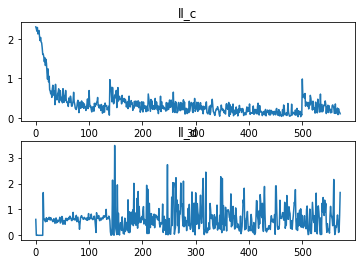

In [52]:
# # XE loss
# ll_c_cpu = ll_c.tolist()

device1 = torch.device("cpu")

ll_c = torch.tensor(ll_c, dtype = torch.float32, device=device1)
ll_d = torch.tensor(ll_d, dtype = torch.float32, device=device1)
# print(llc.dtype)
fig1, ax = plt.subplots(nrows =2, sharex = False)
ax[0].plot(range(len(ll_c)), ll_c)
ax[0].set_title('ll_c')
ax[1].plot(range(len(ll_d)), ll_d)
ax[1].set_title('ll_d')
# Discriminator loss

0.6545

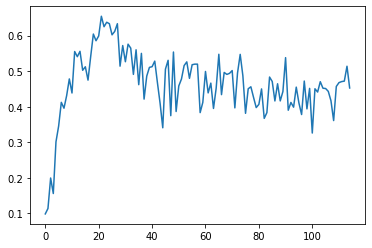

In [53]:
# Accuracy
plt.plot(range(len(acc_lst)), acc_lst)

max(acc_lst)